Our goal is constructing the whole image from its few context points.

**Motivation**: Why are we doing this? Say, for example, you have less bandwidth, but you want to send an image to your friend. What you can do is to compress the image to few context points using NN model and give this compressed image and the model to your friend. Your friend can use this model and these few context points of the original image to reconstruct the whole image. We can also use this for image inpainting, super-resolution, etc.

Simple ways can be as follows, but we have some issues with these approaches:
- For this, if we learn a single neural network for all images, then this will be a general model, but at testing time, we don't have the whole image, so we won't be able to use the same model.
- And if we learn a neural network for each image, then this will be a task-specific model, but at testing time, we don't know which image model to pick for a new image.

So, we use a Meta learning setup using hypernet and neural processes to learn a task-specific neural network that predicts the whole image given a few context points of an image. 

**Why meta?** Because we are learning a model that learns the parameters of another model. 

We use our version of the following to reproduce Figure 4 from the paper referenced at [link](https://proceedings.mlr.press/v80/garnelo18a/garnelo18a.pdf) conditional neural network paper.
- Hypernet
- Neural Processes

<img src="../images/hypernet_neural_process/hypernet_neural.png" width="700">

<a href="https://colab.research.google.com/github/jaiswalsuraj487/Climax_project_autoencoder/blob/main/Hypernet_neural_process_cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [ ]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tqdm import trange

from PIL import Image
import os
from tabulate import tabulate

In [ ]:
# select gpu
device = torch.device("cuda:3")
print(device)
current_device = device #torch.cuda.current_device()
device_name = torch.cuda.get_device_name(current_device)
print(f"Current GPU assigned: {current_device}, Name: {device_name}")

cuda:3
Current GPU assigned: cuda:3, Name: NVIDIA A100-SXM4-80GB


# Loading and preprocessing
- You can download CelebA data from [link](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). We only need images for our task. Extract these images in the same folder as this notebook.

- There are 2,02,599 images in total in CelebA dataset. We will use only 10,000 images for training and 2599 for test dataset. For better results, you can use full dataset.

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, data_root, transform=None):
        self.data_root = data_root
        self.transform = transform
        self.image_files = [f for f in os.listdir(data_root) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_root, self.image_files[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
batch_size = 1 # keep this to 1
img_size = 32 # Change as needed

# Specify the root directory where the dataset is located
data_root = 'data/celeba/img_align_celeba_10000'

# Define the data transformations
transform = transforms.Compose([
    # transforms.Resize((img_size, img_size)),  # Resize the images to a common size (adjust as needed)
    transforms.ToTensor(),   # Convert images to tensors
])
# default shape is torch.Size([3, 218, 178])
# Create the custom dataset
celeba_dataset = CustomImageDataset(data_root, transform=transform)

# Create a data loader
data_loader = DataLoader(celeba_dataset, batch_size=batch_size, shuffle=False)

Original image

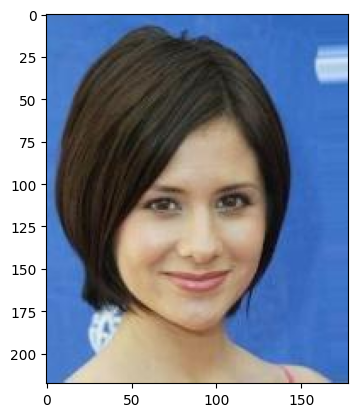

In [ ]:
plt.imshow(torch.einsum('chw -> hwc', data_loader.dataset[33]))

In [ ]:
# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Resize the images to a common size (adjust as needed)
    transforms.ToTensor(),   # Convert images to tensors
])
# default shape is torch.Size([3, 218, 178])
# Create the custom dataset
celeba_dataset = CustomImageDataset(data_root, transform=transform)

# Create a data loader
data_loader = DataLoader(celeba_dataset, batch_size=batch_size, shuffle=False)

Original image after transformation (applying resize to 32x32 to reduce computational cost)

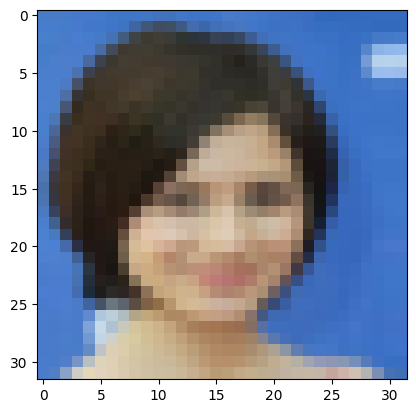

In [ ]:
plt.imshow(torch.einsum('chw -> hwc', data_loader.dataset[33]))

Create a coordinate dataset from the image

In [ ]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height* width, 2) and torch.tensor containing the (num_channels)
    """
    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates
    x_coords = torch.arange(width).repeat(height, 1)
    y_coords = torch.arange(height).repeat(width, 1).t()
    x_coords = x_coords.reshape(-1)
    y_coords = y_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([x_coords, y_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Create a tensor containing the image pixel values
    Y = img.reshape(-1, num_channels).float().to(device)
    return X, Y

<img src="../images/hypernet_neural_process/input_network.png" width="300">

Below is our Loss function. It is negative log likelihood loss. We will use this to train our model. 
This takes: 
- y_pred which is the mean of the predicted distribution and y_true which is the actual value for RGB channels.
- log_sigma which is the log of standard deviation of the predicted distribution for each RGB channel.
- y_true which is the actual value for RGB channels.

We convert list of sigma into identity covariance matrix and then calculate the log probability of the actual value given the predicted distribution with mean list y_pred for each RGB channel and covariance matrix of log_sigma.

In [ ]:
def neg_loglikelyhood(y_pred,log_sigma,y_true):
    cov_matrix = torch.diag_embed(log_sigma.exp())
    dist = torch.distributions.MultivariateNormal(y_pred,cov_matrix,validate_args=False)
    return - dist.log_prob(y_true).sum()

To count the parameter in any model, you can use following code:

In [ ]:
def count_params(model):
    # return torch.sum(p.numel() for p in model.parameters() if p.requires_grad)
    return torch.sum(torch.tensor([p.numel() for p in model.parameters()]))

# Hyper Network

Training phase architecture

<img src="../images/hypernet_neural_process/hypernet_archi_train.png" width="600">

## Model defination

### Target net defination

In [ ]:
# Create a MLP with 5 hidden layers with 256 neurons each and ReLU activations.
# Input is (x, y) and output is (r, g, b) or (g) for grayscale
# here we output 6 values (3 for RGB mean and 3 for RGB std)
s = 128 # hidden dim of model

class TargetNet(nn.Module):
    def _init_siren(self, activation_scale):
        self.fc1.weight.data.uniform_(-1/self.fc1.in_features, 1/self.fc1.in_features)
        for layers in [self.fc2, self.fc3, self.fc4, self.fc5]:
            layers.weight.data.uniform_(-np.sqrt(6/self.fc2.in_features)/activation_scale,
                                        np.sqrt(6/self.fc2.in_features)/activation_scale)

    def __init__(self, activation=torch.relu, n_out=1, activation_scale=1.0):
        super().__init__()
        self.activation = activation
        self.activation_scale = activation_scale
        self.fc1 = nn.Linear(2, s) # input size is 2 (x, y) location of pixel
        self.fc2 = nn.Linear(s, s)
        self.fc3 = nn.Linear(s, s)
        self.fc4 = nn.Linear(s, s)
        self.fc5 = nn.Linear(s, n_out) #gray scale image (1) or RGB (3)
        if self.activation == torch.sin:
            # init weights and biases for sine activation
            self._init_siren(activation_scale=self.activation_scale)

    def forward(self, x):
        x = self.activation(self.activation_scale*self.fc1(x))
        x = self.activation(self.activation_scale*self.fc2(x))
        x = self.activation(self.activation_scale*self.fc3(x))
        x = self.activation(self.activation_scale*self.fc4(x))
        return self.fc5(x)

### Hypernetwork defination

Input: (x, y, R, G, B)

Output: Our Hypernetwork should have the output equal to the number of parameters in the main network.

In [ ]:
# pass total params of target network before calling the hypernetwork model
class HyperNet(nn.Module):
    def __init__(self, total_params, num_neurons=128, activation=torch.relu):
        super().__init__()
        self.activation = activation
        self.n_out = total_params
        self.fc1 = nn.Linear(5, num_neurons)
        self.fc2 = nn.Linear(num_neurons, num_neurons)
        self.fc3 = nn.Linear(num_neurons, self.n_out)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return self.fc3(x)

## Initialize the model and input

### Initialize the target network

In [ ]:
from torchinfo import summary
targetnet = TargetNet(activation=torch.relu, n_out=6, activation_scale=1).to(device)
summary(targetnet, input_size=(img_size* img_size, 2)) #32*32 =1024 is the image size lentgh, 2 is x,y coordinate
# outputs 6: 1,2,3 mean of each channel and 4,5,6 are log sigma of each channel

Layer (type:depth-idx)                   Output Shape              Param #
TargetNet                                [1024, 6]                 --
├─Linear: 1-1                            [1024, 128]               384
├─Linear: 1-2                            [1024, 128]               16,512
├─Linear: 1-3                            [1024, 128]               16,512
├─Linear: 1-4                            [1024, 128]               16,512
├─Linear: 1-5                            [1024, 6]                 774
Total params: 50,694
Trainable params: 50,694
Non-trainable params: 0
Total mult-adds (M): 51.91
Input size (MB): 0.01
Forward/backward pass size (MB): 4.24
Params size (MB): 0.20
Estimated Total Size (MB): 4.45

In [ ]:
targetnet

TargetNet(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=6, bias=True)
)

In [ ]:
count_params(targetnet)

tensor(50694)

### initialize the hypernetwork model

In [ ]:
hypernet = HyperNet(total_params=count_params(targetnet), activation=torch.sin).to(device)
print(hypernet)

HyperNet(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=50694, bias=True)
)


In [ ]:
summary(hypernet,input_size=(img_size* img_size,5))  # 32*32 = 1024 is the image size length, 5 is the input(x,y,r,g,b) to hypernet

Layer (type:depth-idx)                   Output Shape              Param #
HyperNet                                 [1024, 50694]             --
├─Linear: 1-1                            [1024, 128]               768
├─Linear: 1-2                            [1024, 128]               16,512
├─Linear: 1-3                            [1024, 50694]             6,539,526
Total params: 6,556,806
Trainable params: 6,556,806
Non-trainable params: 0
Total mult-adds (G): 6.71
Input size (MB): 0.02
Forward/backward pass size (MB): 417.38
Params size (MB): 26.23
Estimated Total Size (MB): 443.63

In [ ]:
table_data = []
total_params = 0
start = 0
start_end_mapping = {}
for name, param in targetnet.named_parameters():
    param_count = torch.prod(torch.tensor(param.shape)).item()
    total_params += param_count
    end = total_params
    table_data.append([name, param.shape, param_count, start, end])
    start_end_mapping[name] = (start, end)
    start = end

print(tabulate(table_data, headers=["Layer Name", "Shape", "Parameter Count", "Start Index", "End Index"]))
print(f"Total number of parameters: {total_params}")

Layer Name    Shape                     Parameter Count    Start Index    End Index
------------  ----------------------  -----------------  -------------  -----------
fc1.weight    torch.Size([128, 2])                  256              0          256
fc1.bias      torch.Size([128])                     128            256          384
fc2.weight    torch.Size([128, 128])              16384            384        16768
fc2.bias      torch.Size([128])                     128          16768        16896
fc3.weight    torch.Size([128, 128])              16384          16896        33280
fc3.bias      torch.Size([128])                     128          33280        33408
fc4.weight    torch.Size([128, 128])              16384          33408        49792
fc4.bias      torch.Size([128])                     128          49792        49920
fc5.weight    torch.Size([6, 128])                  768          49920        50688
fc5.bias      torch.Size([6])                         6          50688      

### Initialize the input

In [ ]:
corr, vals = create_coordinate_map(data_loader.dataset[0])
corr, vals

(tensor([[ 0.,  0.],
         [ 1.,  0.],
         [ 2.,  0.],
         ...,
         [29., 31.],
         [30., 31.],
         [31., 31.]], device='cuda:3'),
 tensor([[0.4510, 0.4706, 0.4824],
         [0.4745, 0.4745, 0.4471],
         [0.4667, 0.4353, 0.5412],
         ...,
         [0.0314, 0.0549, 0.0471],
         [0.0431, 0.0392, 0.0510],
         [0.0549, 0.0392, 0.0549]], device='cuda:3'))

In [ ]:
scaler_img = preprocessing.MinMaxScaler().fit(corr.cpu())
xy = torch.tensor(scaler_img.transform(corr.cpu())).float().to(device)
xy, xy.shape

(tensor([[0.0000, 0.0000],
         [0.0323, 0.0000],
         [0.0645, 0.0000],
         ...,
         [0.9355, 1.0000],
         [0.9677, 1.0000],
         [1.0000, 1.0000]], device='cuda:3'),
 torch.Size([1024, 2]))

## Training loop

In [ ]:
n_epochs=20
lr = 0.003

targetnet = TargetNet(activation=torch.relu, n_out=6, activation_scale=1).to(device)
hypernet = HyperNet(total_params=count_params(targetnet), activation=torch.relu).to(device)
optimizer = optim.Adam(hypernet.parameters(),lr=lr) # only hypernet is updated

n_context = 100
print("Context Points=",n_context)
for epoch in trange(n_epochs):

    c_idx = np.array(random.sample(range(1023),n_context))

    print("Epoch=",epoch+1)
    epoch_loss = 0
    i=1

    for data in data_loader:
        # print(data.shape)
        optimizer.zero_grad()

        pixel_intensity = data.reshape(3,-1).T.to(device).float()
        input = torch.concatenate([xy[c_idx],pixel_intensity[c_idx]],axis=1).float()

        hyper_out = hypernet(input)
        hyper_out = torch.mean(hyper_out,dim=0)

        target_dict ={}
        for name,param in targetnet.named_parameters():
            start,end = start_end_mapping[name]
            target_dict[name] = hyper_out[start:end].reshape(param.shape)

        img_out = torch.func.functional_call(targetnet, target_dict, xy)
        # print(img_out.shape, img_out[:,:3].shape, img_out[:,3:].shape, pixel_intensity.shape)
        # print( img_out[:,:3], img_out[:,3:], pixel_intensity)
        loss = neg_loglikelyhood(img_out[:,:3],img_out[:,3:],pixel_intensity)
        loss.backward()
        optimizer.step()

        epoch_loss = epoch_loss + loss.item()
        i=i+1

    print("Epoch Loss=",epoch_loss/len(data_loader))


Context Points= 100


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch= 1


  5%|▌         | 1/20 [01:05<20:42, 65.40s/it]

Epoch Loss= -395.47315481672285
Epoch= 2


 10%|█         | 2/20 [02:10<19:37, 65.41s/it]

Epoch Loss= -915.5049703121185
Epoch= 3


 15%|█▌        | 3/20 [03:15<18:29, 65.26s/it]

Epoch Loss= -1166.0503022047044
Epoch= 4


 20%|██        | 4/20 [04:21<17:24, 65.28s/it]

Epoch Loss= -1349.56748127985
Epoch= 5


 25%|██▌       | 5/20 [05:26<16:19, 65.30s/it]

Epoch Loss= -1396.8538594449997
Epoch= 6


 30%|███       | 6/20 [06:31<15:14, 65.31s/it]

Epoch Loss= -1479.6613237543106
Epoch= 7


 35%|███▌      | 7/20 [07:37<14:09, 65.36s/it]

Epoch Loss= -1449.8615832103728
Epoch= 8


 40%|████      | 8/20 [08:42<13:04, 65.38s/it]

Epoch Loss= -1528.4998937654495
Epoch= 9


 45%|████▌     | 9/20 [09:47<11:58, 65.31s/it]

Epoch Loss= -1538.7266953744888
Epoch= 10


 50%|█████     | 10/20 [10:53<10:53, 65.36s/it]

Epoch Loss= -1574.4109719749451
Epoch= 11


 55%|█████▌    | 11/20 [11:58<09:48, 65.35s/it]

Epoch Loss= -1558.2231241334914
Epoch= 12


 60%|██████    | 12/20 [13:03<08:42, 65.32s/it]

Epoch Loss= -1585.886608516693
Epoch= 13


 65%|██████▌   | 13/20 [14:09<07:36, 65.27s/it]

Epoch Loss= -1586.6056880670546
Epoch= 14


 70%|███████   | 14/20 [15:14<06:31, 65.23s/it]

Epoch Loss= -1561.2374246302604
Epoch= 15


 75%|███████▌  | 15/20 [16:19<05:25, 65.20s/it]

Epoch Loss= -1606.3488553873062
Epoch= 16


 80%|████████  | 16/20 [17:24<04:20, 65.24s/it]

Epoch Loss= -1637.4123486403466
Epoch= 17


 85%|████████▌ | 17/20 [18:30<03:15, 65.29s/it]

Epoch Loss= -1656.406247360611
Epoch= 18


 90%|█████████ | 18/20 [19:33<02:09, 64.69s/it]

Epoch Loss= -1621.5405502536773
Epoch= 19


 95%|█████████▌| 19/20 [20:38<01:04, 64.88s/it]

Epoch Loss= -1708.3212175039291
Epoch= 20


100%|██████████| 20/20 [21:44<00:00, 65.21s/it]

Epoch Loss= -1700.857941632271


### saving and loading the model

In [ ]:
torch.save(hypernet.state_dict(), 'hypernet_model_10000.pth')
torch.save(targetnet.state_dict(), 'targetnet_model_10000.pth')

In [ ]:
# Load the hypernet and targetnet models
hypernet = HyperNet(total_params=count_params(targetnet), activation=torch.relu).to(device)
hypernet.load_state_dict(torch.load('hypernet_model_10000.pth'))
hypernet.eval()  # Set the model to evaluation mode


HyperNet(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=50694, bias=True)
)

In [ ]:
targetnet = TargetNet(activation=torch.relu, n_out=6, activation_scale=1).to(device)
targetnet.load_state_dict(torch.load('targetnet_model_10000.pth'))
targetnet.eval()

TargetNet(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=6, bias=True)
)

## Testing

Testing phase architecture

<img src="../images/hypernet_neural_process/hypernet_archi_test_.png" width="600">

loading the test data

In [ ]:
batch_size = 1 # keep this to 1
img_size = 32 # Change as needed

# Specify the root directory where the dataset is located
data_root = '/home/jaiswalsuraj/suraj_work/projects/data/celeba/img_align_celeba_2599'

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Resize the images to a common size (adjust as needed)
    transforms.ToTensor(),   # Convert images to tensors
])
# default shape is torch.Size([3, 218, 178])
# Create the custom dataset
celeba_dataset = CustomImageDataset(data_root, transform=transform)

# Create a data loader
test_data_loader = DataLoader(celeba_dataset, batch_size=batch_size, shuffle=False)

### Plotting the results

In [ ]:
def plot_hypernet(data,hypernet,targetnet,c_idx):

    pixel_intensity = data.reshape(3,-1).T.to(device).float()
    input = torch.concatenate([xy[c_idx],pixel_intensity[c_idx]],axis=1).float()

    hyper_out = hypernet(input) # hyper_out is a tensor of shape (n_context, total_params)
    hyper_out = torch.mean(hyper_out,dim=0) # aggregate across context points

    target_dict ={}
    start = 0
    for name,param in targetnet.named_parameters():
        end = start + param.numel()
        target_dict[name] = hyper_out[start:end].reshape(param.shape)
        start = end

    img_out = torch.func.functional_call(targetnet, target_dict, xy)
    return img_out.cpu().detach()

In [ ]:
c_1 = np.array(random.sample(range(img_size*img_size),1))
c_10 = np.array(random.sample(range(img_size*img_size),10))
c_100 = np.array(random.sample(range(img_size*img_size),100))
c_1000 = np.array(random.sample(range(img_size*img_size),1000))

image_any = test_data_loader.dataset[0]
idx = 0
data = image_any

In [ ]:
plt.figure(figsize=(9,7),constrained_layout=True)
plt.suptitle("HyperNetworks",fontsize=20)
def plot_image(i,j,k, data,hypernet,targetnet, c_idx):
    plt.subplot(i,j,k)
    img = data.permute(1,2,0)
    mask = np.zeros((32,32,3))
    mask[c_idx//32,c_idx%32,:] = 1
    plt.imshow(img*mask)
    plt.title(f"Context: {len(c_idx)}")
    plt.axis('off')

    plt.subplot(i,j,k+4)
    plot_image = plot_hypernet(data,hypernet,targetnet,c_idx)
    plt.imshow(plot_image[:,:3].T.reshape(3,32,32).permute(1,2,0))
    plt.axis('off')

    plt.subplot(i,j,k+8)
    var =plot_image[:,3:].exp().T.reshape(3,32,32).permute(1,2,0)
    var = var-var.min()
    var = var/var.max()
    plt.imshow(var)
    plt.axis('off')

<Figure size 900x700 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/jaiswalsuraj/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


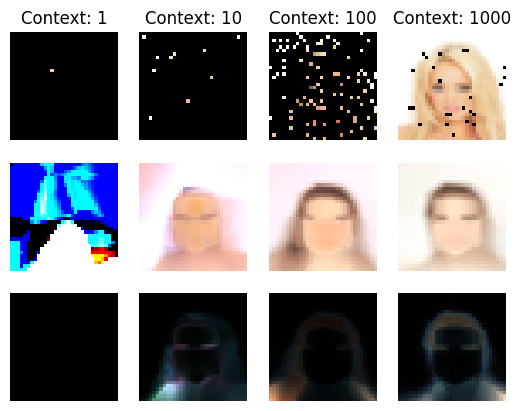

In [ ]:
plot_image(3,4,1,data,hypernet,targetnet,c_1)
plot_image(3,4,2,data,hypernet,targetnet,c_10)
plot_image(3,4,3,data,hypernet,targetnet,c_100)
plot_image(3,4,4,data,hypernet,targetnet,c_1000)

The first row shows the test context points, second row shows our model prediction and third row shows the variance of the predicted image.

# Neural Processes

Training phase architecture

<img src="../images/hypernet_neural_process/neural_process_archi_train.png" width="600">

## Encoder Decoder model defination

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim,activation=torch.sin,activation_scale=30.0):
        super().__init__()
        self.activation = activation
        self.activation_scale = activation_scale
        if activation != torch.sin:
            self.activation_scale = 1.0

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        x = self.activation(self.linear1(x)*self.activation_scale)
        x = self.activation(self.linear2(x)*self.activation_scale)
        return self.linear3(x)

class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim,activation=torch.sin,activation_scale=30.0):
        super().__init__()
        self.activation = activation
        self.activation_scale = activation_scale
        if activation != torch.sin:
            self.activation_scale = 1.0
        self.linear1 = nn.Linear(z_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.linear4 = nn.Linear(hidden_dim, hidden_dim)
        self.linear5 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.activation(self.linear1(x)*self.activation_scale)
        x = self.activation(self.linear2(x)*self.activation_scale)
        x = self.activation(self.linear3(x)*self.activation_scale)
        x = self.activation(self.linear4(x)*self.activation_scale)
        return self.linear5(x)

In [ ]:
from torchinfo import summary
encoder = Encoder(5, 256, 128, activation=torch.relu,activation_scale=1)
summary(encoder,input_size=(img_size*img_size,5)) # 32*32 = 1024 is the image size length, 5 is the input(x,y,r,g,b) to hypernet

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [1024, 128]               --
├─Linear: 1-1                            [1024, 256]               1,536
├─Linear: 1-2                            [1024, 256]               65,792
├─Linear: 1-3                            [1024, 128]               32,896
Total params: 100,224
Trainable params: 100,224
Non-trainable params: 0
Total mult-adds (M): 102.63
Input size (MB): 0.02
Forward/backward pass size (MB): 5.24
Params size (MB): 0.40
Estimated Total Size (MB): 5.66

In [ ]:
print(encoder)

Encoder(
  (linear1): Linear(in_features=5, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=128, bias=True)
)


In [ ]:
decoder = Decoder(130, 256, 6, activation=torch.relu,activation_scale=1)
summary(decoder,input_size=(img_size*img_size,130))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [1024, 6]                 --
├─Linear: 1-1                            [1024, 256]               33,536
├─Linear: 1-2                            [1024, 256]               65,792
├─Linear: 1-3                            [1024, 256]               65,792
├─Linear: 1-4                            [1024, 256]               65,792
├─Linear: 1-5                            [1024, 6]                 1,542
Total params: 232,454
Trainable params: 232,454
Non-trainable params: 0
Total mult-adds (M): 238.03
Input size (MB): 0.53
Forward/backward pass size (MB): 8.44
Params size (MB): 0.93
Estimated Total Size (MB): 9.90

In [ ]:
print(decoder)

Decoder(
  (linear1): Linear(in_features=130, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=256, bias=True)
  (linear5): Linear(in_features=256, out_features=6, bias=True)
)


## Initialize the input

In [ ]:
corr, vals = create_coordinate_map(data_loader.dataset[0])
corr, vals

(tensor([[ 0.,  0.],
         [ 1.,  0.],
         [ 2.,  0.],
         ...,
         [29., 31.],
         [30., 31.],
         [31., 31.]], device='cuda:2'),
 tensor([[0.4510, 0.4706, 0.4824],
         [0.4745, 0.4745, 0.4471],
         [0.4667, 0.4353, 0.5412],
         ...,
         [0.0314, 0.0549, 0.0471],
         [0.0431, 0.0392, 0.0510],
         [0.0549, 0.0392, 0.0549]], device='cuda:2'))

In [ ]:
scaler_img = preprocessing.MinMaxScaler().fit(corr.cpu())
xy = torch.tensor(scaler_img.transform(corr.cpu())).float().to(device)
xy, xy.shape

(tensor([[0.0000, 0.0000],
         [0.0323, 0.0000],
         [0.0645, 0.0000],
         ...,
         [0.9355, 1.0000],
         [0.9677, 1.0000],
         [1.0000, 1.0000]], device='cuda:2'),
 torch.Size([1024, 2]))

## Training loop

In [ ]:
n_epochs=20
lr = 0.003
n_context = 200
print("Context Points=",n_context)

encoder = Encoder(input_dim=5, hidden_dim=512, z_dim=128,activation=torch.relu,activation_scale=1).to(device)
decoder = Decoder(z_dim=130, hidden_dim=512, output_dim=6,activation=torch.relu,activation_scale=1).to(device)
optimizer = optim.Adam(list(encoder.parameters())+list(decoder.parameters()),lr=lr)

for epoch in trange(n_epochs):

    c_idx = np.array(random.sample(range(1023),n_context))

    print("Epoch=",epoch+1)
    epoch_loss = 0
    i=1
    for data in data_loader:
        # print(data.shape)

        optimizer.zero_grad()

        pixel_intensity = data.reshape(3,-1).T.to(device).float()
        input = torch.concatenate([xy[c_idx],pixel_intensity[c_idx]],axis=1).float()

        encoder_out = encoder(input)
        encoder_out = torch.mean(encoder_out,dim=0)

        decoder_in = encoder_out.repeat(1024,1)
        decoder_in = torch.concatenate([xy,decoder_in],axis=1)

        img_out = decoder(decoder_in)

        loss = neg_loglikelyhood(img_out[:,:3],img_out[:,3:],pixel_intensity)
        loss.backward()
        optimizer.step()

        epoch_loss = epoch_loss + loss.item()
        i=i+1
    print("Epoch Loss=",epoch_loss/len(data_loader))


Context Points= 200


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch= 1


  5%|▌         | 1/20 [00:58<18:27, 58.30s/it]

Epoch Loss= 47.26116828255653
Epoch= 2


 10%|█         | 2/20 [01:50<16:27, 54.89s/it]

Epoch Loss= -455.4421627301693
Epoch= 3


 15%|█▌        | 3/20 [02:43<15:16, 53.92s/it]

Epoch Loss= -683.1707640041351
Epoch= 4


 20%|██        | 4/20 [03:35<14:13, 53.32s/it]

Epoch Loss= -761.2885692318916
Epoch= 5


 25%|██▌       | 5/20 [04:36<13:56, 55.78s/it]

Epoch Loss= -827.9153870079041
Epoch= 6


 30%|███       | 6/20 [05:35<13:20, 57.17s/it]

Epoch Loss= -938.4062066322326
Epoch= 7


 35%|███▌      | 7/20 [06:30<12:11, 56.24s/it]

Epoch Loss= -1007.5277942465782
Epoch= 8


 40%|████      | 8/20 [07:30<11:28, 57.39s/it]

Epoch Loss= -1048.726986592865
Epoch= 9


 45%|████▌     | 9/20 [08:20<10:06, 55.15s/it]

Epoch Loss= -1057.8311284263611
Epoch= 10


 50%|█████     | 10/20 [09:17<09:17, 55.74s/it]

Epoch Loss= -1070.1760208235742
Epoch= 11


 55%|█████▌    | 11/20 [09:56<07:34, 50.50s/it]

Epoch Loss= -1065.5062245418549
Epoch= 12


 60%|██████    | 12/20 [10:35<06:16, 47.06s/it]

Epoch Loss= -1078.0465439793586
Epoch= 13


 65%|██████▌   | 13/20 [11:14<05:13, 44.75s/it]

Epoch Loss= -1088.4120592634201
Epoch= 14


 70%|███████   | 14/20 [11:53<04:17, 42.99s/it]

Epoch Loss= -1078.4957633354188
Epoch= 15


 75%|███████▌  | 15/20 [12:32<03:28, 41.78s/it]

Epoch Loss= -1084.8360796244622
Epoch= 16


 80%|████████  | 16/20 [13:11<02:43, 40.94s/it]

Epoch Loss= -1093.4410486424447
Epoch= 17


 85%|████████▌ | 17/20 [13:50<02:01, 40.44s/it]

Epoch Loss= -1113.8205106693267
Epoch= 18


 90%|█████████ | 18/20 [14:29<01:19, 39.99s/it]

Epoch Loss= -1110.6333978479386
Epoch= 19


 95%|█████████▌| 19/20 [15:25<00:44, 44.66s/it]

Epoch Loss= -1098.3281953195572
Epoch= 20


100%|██████████| 20/20 [16:25<00:00, 49.28s/it]

Epoch Loss= -1106.2516599431992


### saving and loading the model

In [ ]:
torch.save(encoder.state_dict(), 'encoder_model_10000.pth')
torch.save(decoder.state_dict(), 'decoder_model_10000.pth')

In [ ]:
# Load the hypernet and targetnet models
encoder = Encoder(input_dim=5, hidden_dim=128, z_dim=128,activation=torch.relu,activation_scale=1).to(device)

encoder.load_state_dict(torch.load('encoder_model_10000.pth'))
encoder.eval()  # Set the model to evaluation mode


Encoder(
  (linear1): Linear(in_features=5, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=128, bias=True)
)

In [ ]:
decoder = Decoder(z_dim=130, hidden_dim=256, output_dim=6,activation=torch.relu,activation_scale=1).to(device)
decoder.load_state_dict(torch.load('decoder_model_10000.pth'))
decoder.eval()

Decoder(
  (linear1): Linear(in_features=130, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=256, bias=True)
  (linear5): Linear(in_features=256, out_features=6, bias=True)
)

## Testing

Testing phase architecture

<img src="../images/hypernet_neural_process/neural_process_archi_test.png" width="600">

Loading the test data

In [ ]:
batch_size = 1 # keep this to 1
img_size = 32 # Change as needed

# Specify the root directory where the dataset is located
data_root = 'data/celeba/img_align_celeba_2599'

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Resize the images to a common size (adjust as needed)
    transforms.ToTensor(),   # Convert images to tensors
])
# default shape is torch.Size([3, 218, 178])
# Create the custom dataset
celeba_dataset = CustomImageDataset(data_root, transform=transform)

# Create a data loader
test_data_loader = DataLoader(celeba_dataset, batch_size=batch_size, shuffle=False)

### Plotting the results

In [ ]:
def plot_enc_dec(data,encoder,decoder,c_idx):

    pixel_intensity = data.reshape(3,-1).T.to(device).float()
    input = torch.concatenate([xy[c_idx],pixel_intensity[c_idx]],axis=1).float()

    encoder_out = encoder(input)
    encoder_out = torch.mean(encoder_out,dim=0)

    decoder_in = encoder_out.repeat(1024,1)
    decoder_in = torch.concatenate([xy,decoder_in],axis=1)

    img_out = decoder(decoder_in)
    return img_out.cpu().detach()

In [ ]:
c_1 = np.array(random.sample(range(img_size*img_size),1))
c_10 = np.array(random.sample(range(img_size*img_size),10))
c_100 = np.array(random.sample(range(img_size*img_size),100))
c_1000 = np.array(random.sample(range(img_size*img_size),1000))

idx = 5
image_any = test_data_loader.dataset[idx]
data = image_any

In [ ]:
plt.figure(figsize=(9,7),constrained_layout=True)
plt.suptitle("Neural process",fontsize=20)
def plot_image(i,j,k, data,encoder,decoder, c_idx):
    plt.subplot(i,j,k)
    img = data.permute(1,2,0)
    mask = np.zeros((32,32,3))
    mask[c_idx//32,c_idx%32,:] = 1
    plt.imshow(img*mask)
    plt.title(f"Context: {len(c_idx)}")
    plt.axis('off')

    plt.subplot(i,j,k+4)
    plot_image = plot_enc_dec(data,encoder,decoder,c_idx)
    plt.imshow(plot_image[:,:3].T.reshape(3,32,32).permute(1,2,0))
    plt.axis('off')

    plt.subplot(i,j,k+8)
    var =plot_image[:,3:].exp().T.reshape(3,32,32).permute(1,2,0)
    var = var-var.min()
    var = var/var.max()
    plt.imshow(var)
    plt.axis('off')

<Figure size 900x700 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


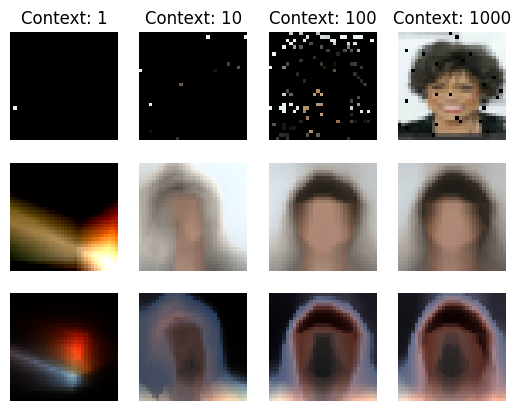

In [ ]:
plot_image(3,4,1,data,encoder,decoder,c_1)
plot_image(3,4,2,data,encoder,decoder,c_10)
plot_image(3,4,3,data,encoder,decoder,c_100)
plot_image(3,4,4,data,encoder,decoder,c_1000)

The first row shows the test context points, second row shows our model prediction and third row shows the variance of the predicted image.

# Conclusion
- Here we have seen some implementaion of meta learning using hypernet and neural processes.
- Further we can improve if we use sin activation function in the model for image like data. Refer [link](https://arxiv.org/pdf/2006.09661.pdf) for more details.

The saga concludes with a symphony of learning, as Hypernets and Neural Processes rewrite the narrative of image reconstruction on CelebA, transforming a complex challenge into a melodious solution.